# Bar Crawl: 
## Classifying elevated transdermal alcohol concentration (TAC) using phone accelerometer data

Excessive drinking poses risks to an individual's health (e.g. alcohol poisoning or death) as well as personal and public safety (e.g. vehicular accidents). Moreover, inebriation reduces awareness of one's own impairment and hinders judgment to avoid such potentially dangerous behaviors. This analysis aims at providing an intervention to excessive consumption and risky behaviors, predicting when transdermal alcohol concentration (TAC, a proxy for blood alcohol concentration) are above legal limits for driving using observations of subject movement as measured by their mobile phone accelerometer. 

The data used for this analysis is credited to Jackson A Killian (Harvard University), Danielle R Madden (USC), and John Clapp (USC). These data are publicly available at:

> https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking

> https://archive.ics.uci.edu/ml/machine-learning-databases/00515/data.zip (direct link to download)

And the authors initial analyses are detailed in:

> Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42)

To run the following notebook, you will need to download and unzip the data folder to your current working directory.


## Contents of Analysis

 - [Inspect Data and Initial Cleanup](#inspection)
 - [Extract Windowed Samples and Transform Data](#transform)
 - [Create Features](#features)
 - [Fit Models and Assess Performance](#models)

## Results



In [1]:
# Use saved data to run cells from later sections.
# False, all the data prep done from scratch.

USE_SAVED=True

# Setup

Install required packages (requirement.txt) into your working Python environment. Run "make install" in the command line of the working directory.

Packages are imported as needed in the different sections of this analysis. 
I reduce data size (converting data types to smallest suitable) and converting original .csv files into .ftr (feather) using code from github user fujiyuu75 (cited in BarCrawl_helpers). 

In [2]:
from os import listdir, walk, environ
from os.path import isfile, join, exists

import requests
import pickle

from BarCrawl_helpers import *

import numpy as np
import pandas as pd

from scipy.signal import spectrogram
from scipy.interpolate import interp1d

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import re as re
from tqdm import tqdm

import sys
import warnings

warnings.filterwarnings('ignore')

In [3]:
TAC_limit = 0.08

# Cartesian Accelerations and their PCA components (top 2 of 3)
xyz = ['x', 'y', 'z']
C = ['C1', 'C2']

# Spherical Accelerations and their PCA components (top 2 of 3)
rtp = ['rho', 'theta', 'phi']
S = ['S1', 'S2']

<a id='inspection'></a>
# Fetch Data and Initial Inspection

 - get data from Kaggle
 - create data folder
 - reduce memory usage (see citation for borrowed code snippet)
 - convert .csv to .ftr (feather) for faster loading in future runs




## Make Dataframes and Split Accelerometer Data by Subject 

In [4]:
datafolder = 'feather_data'

if not exists('./feather_data'):
    file_list = [os.path.join('data', 'clean_tac', file) for file in os.listdir(os.path.join('data', 'clean_tac')) if file[-3:]=='csv']
    file_list = file_list + [os.path.join('data', 'all_accelerometer_data_pids_13.csv'), os.path.join('data','phone_types.csv')]

    os.mkdir(datafolder)
    [csv2feather(file, datafolder=datafolder) for file in file_list]



In [5]:
acc_datafile = 'all_accelerometer_data_pids_13.ftr'
phone_datafile = 'phone_types.ftr'


all_acc_df = pd.read_feather(join(datafolder, acc_datafile))
phones_df = pd.read_feather(join(datafolder, phone_datafile))

In [6]:
all_acc_df.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [7]:
# make a dictionary of TAC files with keys being subject PIDs
# # pattern = re.compile(r'\D{2}\d{4}')
# pattern = re.compile(r'\D{2}\d{4}')
# tac_files = [filename if re.match(r'\D{2}\d{4}',filename) for filename in listdir(datafolder)].sort()

tac_files = sorted([filename for filename in listdir(datafolder) if re.match(r'\D{2}\d{4}',filename)])
pid_list = [filename[0:6] for filename in tac_files]

tac_df = {}

for tac_file in tac_files:
    pid = tac_file[0:6]
    if tac_file.endswith('.ftr'):
        tac_df[pid] = pd.read_feather(join(datafolder, tac_file))
    elif tac_file.endswith('.csv'):
        tac_df[pid] = pd.read_csv(join(datafolder, tac_file))
    else:
        print('%s is neither a .csv or .ftr' % tac_file)

In [8]:
acc_df = {}

for pid in pid_list:
    acc_df[pid] = all_acc_df[all_acc_df.pid==pid].reset_index().drop(columns = 'index')

## Initial inspection

Notes:

 - acceleration time stamps in milliseconds sampled nominally at 40 Hz
 - some subjects' acceleration data starts with a spurious zero reading
 - TAC time stamps in seconds

(3, 9)


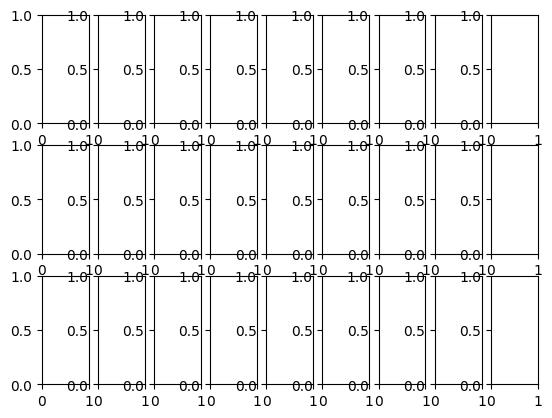

In [9]:
fig, ax = plt.subplots(3,9)
print(ax.shape)

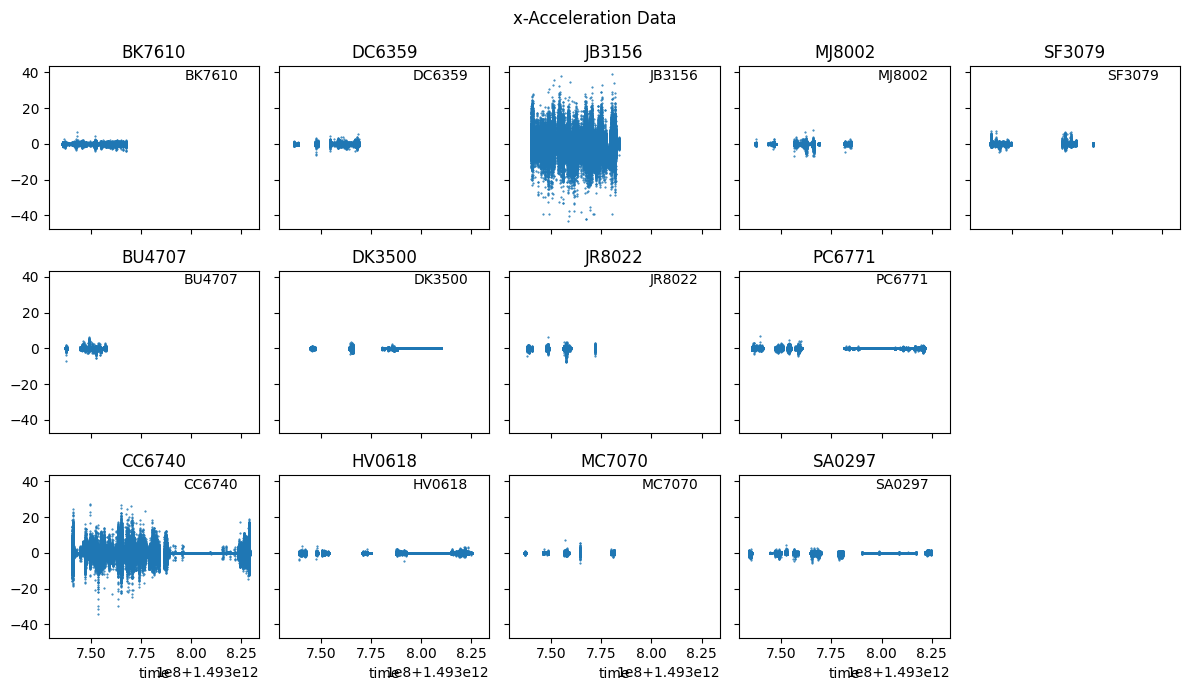

In [10]:
fig, ax = plt.subplots(3,5, figsize=(12,7), sharex=True, sharey = True)

direction = 'x';

for k, pid in enumerate(pid_list):
    i,j = get_ax_ij(k, ax)
    acc_df[pid].iloc[1:-1].plot(x='time', y = direction, marker = '.', markersize = 1, linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))], legend=False)
    ax[i,j].set_title(pid)
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)
        
fig.suptitle(f'{direction}-Acceleration Data')
fig.delaxes(ax[1,4])
fig.delaxes(ax[2,4])
plt.tight_layout()
plt.show()

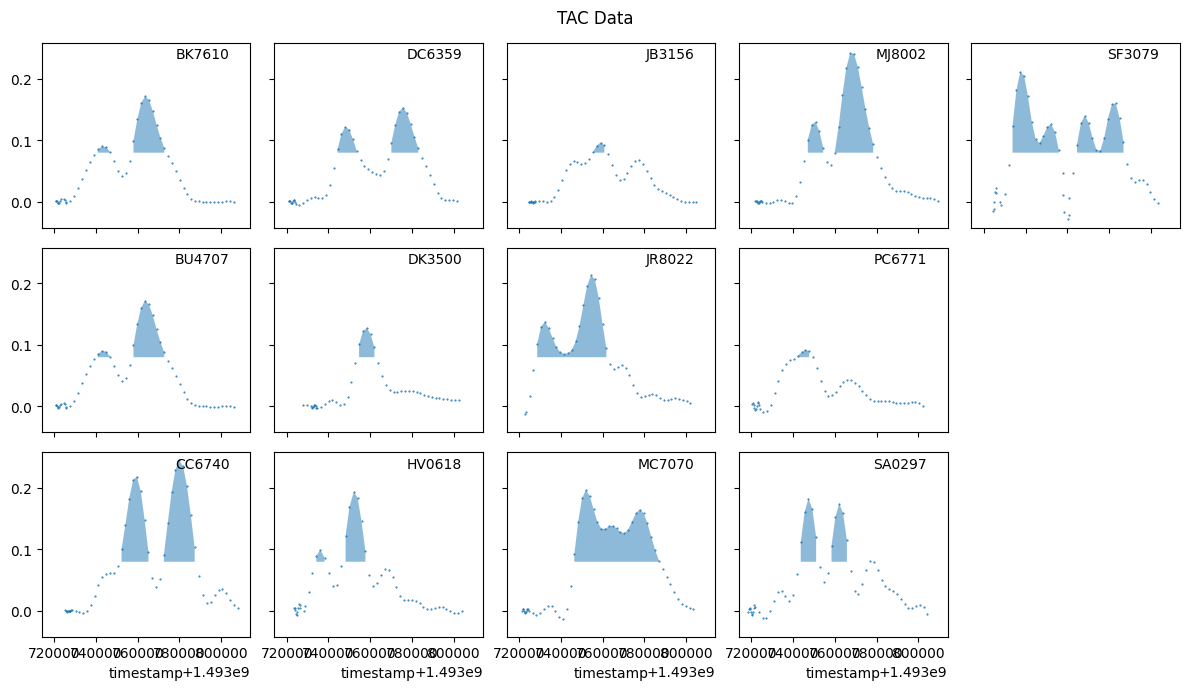

In [11]:
fig, ax = plt.subplots(3,5, figsize=(12,7), sharey=True, sharex=True)


for k, pid in enumerate(pid_list):
    df = tac_df[pid].iloc[1:-1]
    i,j = get_ax_ij(k, ax)
    df.plot(x='timestamp', y = 'TAC_Reading', marker = '.', markersize=1, linestyle = 'none', ax = ax[i,j], legend=False)
    ax[i,j].fill_between(df['timestamp'], TAC_limit, df['TAC_Reading'], where = df['TAC_Reading']>=TAC_limit, alpha=0.5)
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)
    
fig.suptitle('TAC Data')
fig.delaxes(ax[1,4])
fig.delaxes(ax[2,4])
plt.tight_layout()
plt.show()

## Observations

 - every subject has patches of missing data
 - subjects JB3156 and CC6740 accelerometer data looks categorically different; coincidentally, both subjects use Android phones. For now, I'll restrict the analysis to iPhone data.
 - TAC data looks okay

# Clean Up Data

 - Remove unusable subject data
 - Convert accelerometer time to seconds and resample TAC to align with accelerometer timestamps
 - Snip out 8 sec clips. Why 8 sec? We're attempting to infer blood alcohol levels from accelerations induced by the subjects' movement patterns. If the acceleration data encodes bouts of walking, a rhythmic behavior, the frequency content of acceleration signals could be useful. Typically, h Most notably,  though we may also find accelerations suggesting the subject has fallen or dropped their phone.



In [12]:
pid_remove = ['JB3156', 'CC6740']

for pid in pid_remove:
    if pid in pid_list:
        pid_list.remove(pid)
    acc_df.pop(pid, None)
    tac_df.pop(pid, None)

In [13]:
for pid in pid_list:
    try:
        tac_df[pid].rename(columns={'timestamp':'time_s'}, inplace=True)
        acc_df[pid]['time_s'] = acc_df[pid]['time'].to_numpy()/1000
        del acc_df[pid]['time']
    except:
        print('already been done')
    
    linear_interp = interp1d(tac_df[pid]['time_s'].to_numpy(), tac_df[pid]['TAC_Reading'], kind='linear', axis=0, bounds_error=False)
    acc_df[pid]['tac'] = linear_interp(acc_df[pid]['time_s'].to_numpy())
    
    acc_df[pid].dropna(axis=0, how = 'any', inplace=True)   # tac readings extend past accelerometer readings, so trim down where extrapolation gives Null tac values
    
    tac_df[pid]['time_s'] = tac_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]
    acc_df[pid]['time_s'] = acc_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]

pickle.dump((acc_df, tac_df), open("results/acc_tac.p","wb"))




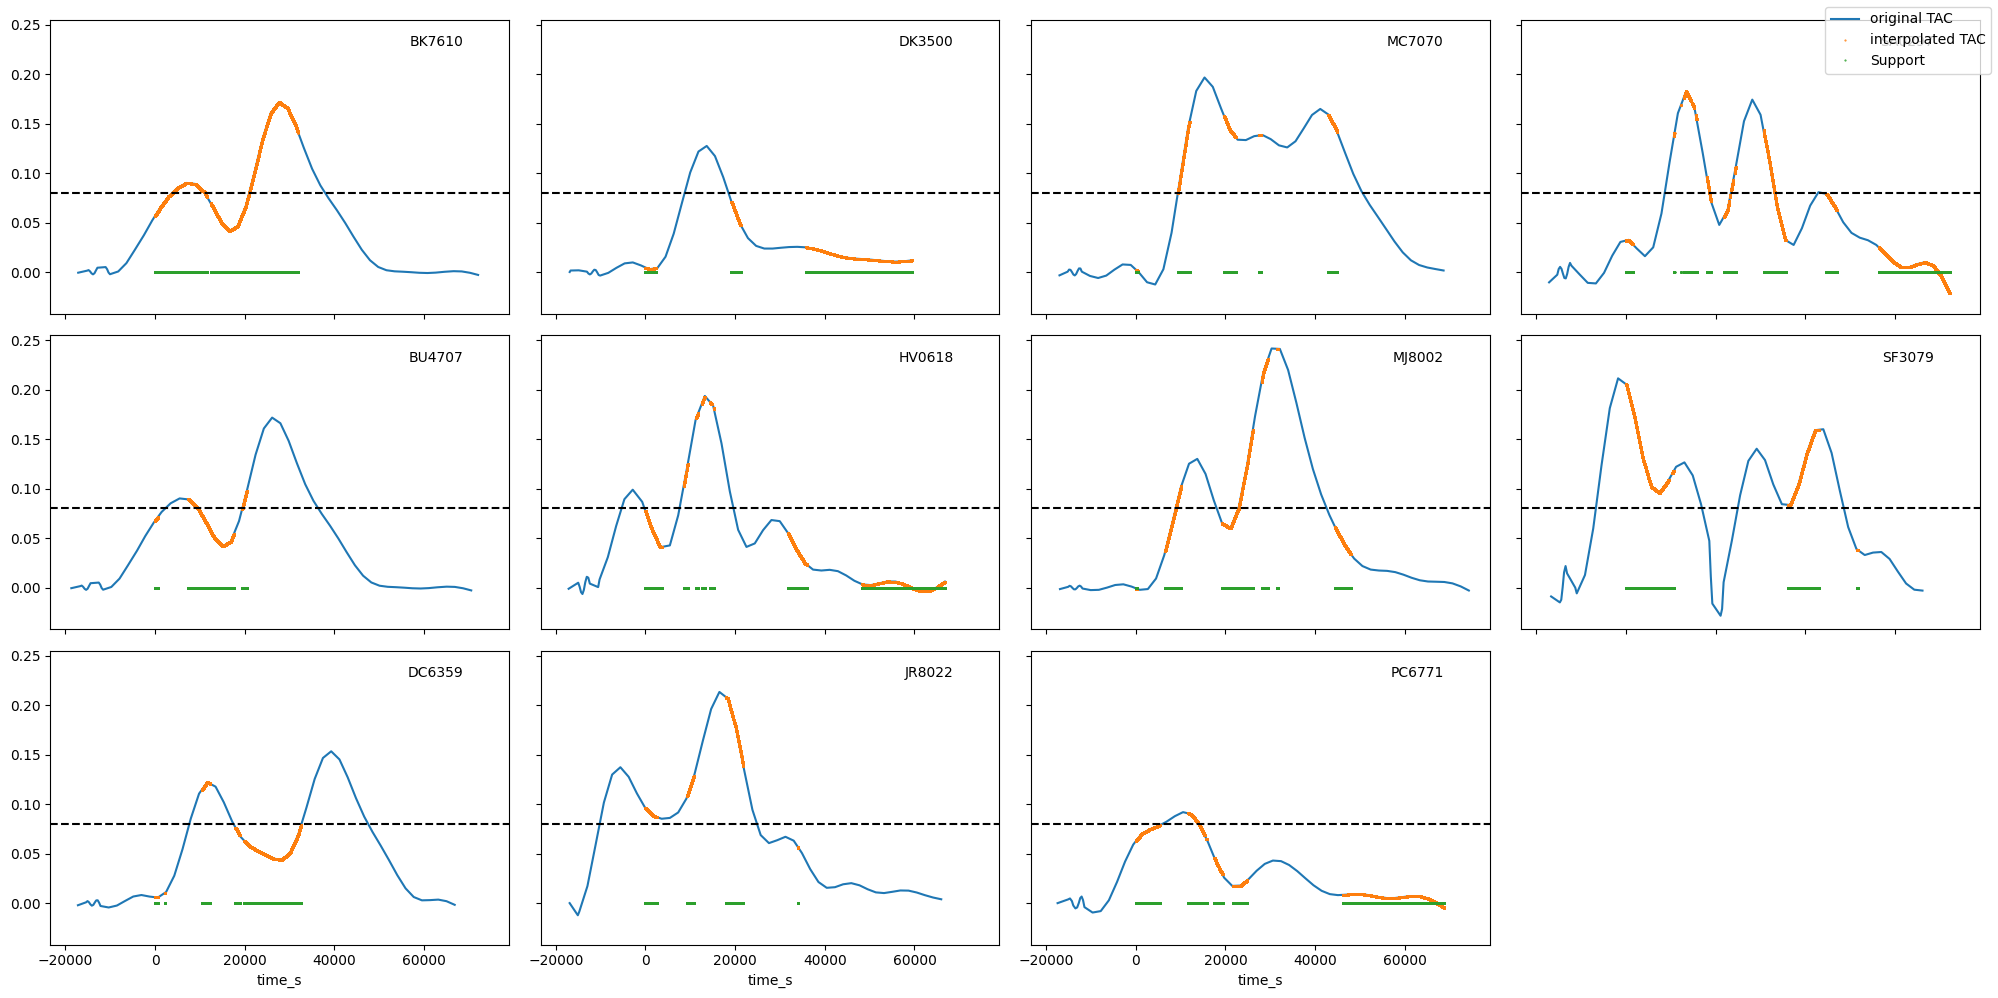

In [82]:
fig, ax = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)

for k, pid in enumerate(pid_list):
    i,j = get_ax_ij(k,ax)
    tac_df[pid].plot(x='time_s', y = 'TAC_Reading', ax = ax[i,j], \
                                     legend=False)
    acc_df[pid].plot(x='time_s', y = 'tac', ax = ax[i,j], \
                                     marker = '.', markersize = 1,linestyle = 'none',\
                                     legend=False)
    ax[i,j].plot(acc_df[pid].time_s, np.zeros(len(acc_df[pid].time_s)), \
                                                    marker = '.', markersize = 1, linestyle = 'none')
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)

    ax[i,j].axhline(TAC_limit, color = 'k', linestyle = '--')

lines = ax[0,0].get_lines()
labels = ['original TAC', 'interpolated TAC', 'Support']
fig.legend(lines, labels)

fig.delaxes(ax[2,3])
plt.tight_layout()
plt.show()

### Observations

 - Most of the TAC data collected does not have corresponding accelerometer data.
 - Most subjects have very imbalanced representation of sober and intoxicated states; some only have one state captured (e.g. DK3500 data captures only sober state, JR8022 and SF3079 data captures only over the limite state). 
 - For my purposes (practice), subject data will be lumped to train a single model and, taken on the whole, there is enough data from each class to train without concern for balance. It would be preferable (and more realistic for a product) to train individual models,  My expectations are tempered.

<a id='transform'></a>
# Transforming Data

Above, the usable data (bands for which there is logged accelerometer data), are parsed into 10 sec windows with 50% overlap; each window has 5 seconds of unique data with the first and last 2.5 seconds shared with the neighboring windows. The following transforms are applied:

 - **Cartesian to Spherical coordinates** -- This is a non-linear coordinate transform that may reveal something useful
 - **PCA** - Principle component analysis is an orthogonal projection. As a result, principle axes are a rotation of the original x-y-z. I keep the first two principle components. The idea behind this transform is that if a subject is performing the same behavior (e.g. walking) sometimes holding their phone landscape or portrait and other times carrying their phone in their pocket, that motion would project onto different x-y-z directions. PCA should rotate the axes to align them with directions that best capture the variance induced by motion. PCA is applied to accelerations represented in both Cartesian and spherical coordinates. 
 - **Fourier transform** - both the Cartesian and spherical accelerations, as well as their PCs, are transformed using the FFT (fast Fourier transform) to represent the signals in frequency domain. This representation should capture rhythmic motions such as walking and swaying. Changes in the frequency domain may represent changes in gait. The 10 second window provides a frequency resolution of 0.1 Hz (1/10s) and the 40 Hz sampling rate results in a Nyquist frequency of 20 Hz. Human step frequency is nominally 2 Hz, but may vary significantly between subjects and levels of inebriation (that's what I'm hoping).

Glossary:

 - pid -- subject id
 - sid -- sample id referencing a 10 sec window
 - x,y,z -- raw accelerations from phone represented in Cartesian coordinates
 - rho, theta, phi -- accelerations in spherical coordinates
 - C1, C2, S1, S2 -- the first two principle components of Cartesian and spherical accelerations

In [15]:
# Cartesian Accelerations and their PCA signals
xyz = ['x', 'y', 'z']
C = ['C1', 'C2']

# Spherical Accelerations and their PCA signals
rtp = ['rho', 'theta', 'phi']
S = ['S1', 'S2']

#ica = FastICA(n_components=2, algorithm = 'parallel', whiten = 'arbitrary-variance', tol=1e-3, max_iter=500)
pca = PCA(n_components=2)

In [16]:
if exists('results/subject_data.p') and USE_SAVED:
    subject_data =pickle.load(open("results/subject_data.p","rb"))
else:

    win_sec = 10  # sliding window in seconds
    win = win_sec * 40   # sliding window size in number of samples

    per_overlap = 0.25
    slide = 1 - per_overlap

    win_overlap = int(np.floor(per_overlap * win))
    win_slide = int(np.ceil(slide * win))

    win_14 = int(np.floor(0.25 * win))  # 1/4 window size. Sampling 10 sec at 40Hz, gives an fft from [-20,20] Hz with resolution of 0.1 Hz. The first win_14 samples correspond to freqs in range [0-10) Hz 

    subject_data = {}

    for pid in pid_list:
        print(f"{pid}...")
        
        acc_df[pid].dropna(axis=0, how = 'any')
        # lenData = len(acc_df[pid].time_s)
        # gap_idx = np.argwhere([np.diff(acc_df[pid].time_s)>0.25])[:,1] + 1  # Mark the leading edges of gaps as anywhere the time increment jumps by a 1/4 second (at least 10 missing samples)
        
        # gap_start_idx = np.append(np.array([0]), gap_idx)  # add the zero idx to the beginning of the array
        # gap_end_idx = np.append(gap_idx, np.array([lenData-1]))
        
        # band_pairs = np.vstack((gap_start_idx, gap_end_idx)).transpose() # pair the beginning and end indices ([idx0, idx1], [idx1, idx2], etc.)
        # band_sizes = np.squeeze(np.diff(band_pairs, axis=1))
        
        dt = np.diff(acc_df[pid].time_s)
        band_pairs = parse_array(dt, gap_width = 0.25)   # returns indices of data segments parsed at time discontinutities of greater than 1/4 sec (10 consecutive missing accelerometer readings)
        band_sizes = np.squeeze(np.diff(band_pairs, axis=1))
        
        sample = []
        sample_fft = []
        sample_count = 0
        
        for k, band_size in tqdm(enumerate(band_sizes)):
            if band_size>win:
                start_idx = int((((band_size-win_overlap)%(win_slide))/2) + band_pairs[k,0]) # This centers the windows on the band of data (e.g. a 15 second band would house a 10 sec window on the interval (2.5,12.5))
                while (start_idx + win) < band_pairs[k, 1]: # while there's room for another window
                    s = acc_df[pid].iloc[start_idx:(start_idx+win)].reset_index().drop(columns='index')
                    s = s.assign(sid=sample_count) # assign each window a sample id (sid). This value is the same for all data in the same window
                    
                    s[rtp] = cart_to_spherical(s[xyz].to_numpy())
                    # mmm = np.linalg.norm(s[xyz].to_numpy(), axis = 1)
                    # s['rho'] = np.linalg.norm(s[xyz].to_numpy(), axis = 1)   # Just using rho, vector magnitude
                    
                    s[C] = pca.fit_transform(s[xyz].to_numpy())
                    s[S] = pca.fit_transform(s[rtp].to_numpy())
                    
                    
                    sf = s[['pid', 'sid']].iloc[0:win_14]
                    
                    sf['freq'] = np.fft.fftfreq(win, 0.025)[0:win_14]
                    sf[xyz] = np.abs(np.fft.fft(s[xyz].to_numpy(), axis=0))[0:win_14,:]
                    sf[rtp] = np.abs(np.fft.fft(s[rtp].to_numpy(), axis=0))[0:win_14,:]
                    
                    sf[C] = np.abs(np.fft.fft(s[C].to_numpy(), axis=0))[0:win_14,:]
                    sf[S] = np.abs(np.fft.fft(s[S].to_numpy(), axis=0))[0:win_14,:]
                    
                    sample_count+=1
                    
                    sample.append(s[['pid', 'sid', 'tac', 'time_s'] + xyz + C + rtp + S])
                    sample_fft.append(sf[['pid', 'sid', 'freq'] + xyz + C + rtp + S])
                    
                    start_idx += win_slide
        
        sample_df = pd.concat(sample).reset_index()
        sample_df.drop(columns = 'index', inplace=True)
        
        sample_fft_df = pd.concat(sample_fft).reset_index()
        sample_fft_df.drop(columns = 'index', inplace=True)

        subject_data[pid] = {'sample':sample_df, 'sample_fft':sample_fft_df}

    print('...done.')

    pickle.dump(subject_data, open("results/subject_data.p","wb"))

In [17]:
# Check sid transitions after 400 time steps
subject_data[pid]['sample'].iloc[395:405]

,pid,sid,tac,time_s,x,y,z,C1,C2,rho,theta,phi,S1,S2
395,SF3079,0,0.205429,11.079,0.0025,0.0097,0.0046,-0.003934,0.002140,0.011023,1.318548,1.140290,2.742370,0.172140
396,SF3079,0,0.205429,11.118,-0.0016,0.0102,-0.0056,-0.014050,-0.001530,0.011746,1.726380,2.067765,3.170553,1.090397
397,SF3079,0,0.205429,11.143,0.0091,-0.0013,-0.0138,-0.021929,0.001104,0.016581,-0.141880,2.553959,1.313474,1.617672
398,SF3079,0,0.205429,11.158,-0.0049,0.0063,0.0286,0.020365,-0.004855,0.029693,2.231821,0.272126,3.636301,-0.715934
399,SF3079,0,0.205429,11.181,0.0022,0.0091,0.0179,0.009383,0.002165,0.020200,1.333583,0.481885,2.742895,-0.486428
400,SF3079,1,0.205437,8.705,0.0082,0.0079,0.0091,0.002317,-0.005965,0.014576,0.766767,0.896533,1.980872,-0.173241
401,SF3079,1,0.205437,8.743,0.0024,0.0119,0.0012,-0.003008,-0.005364,0.012199,1.371778,1.472257,1.387524,0.414501
402,SF3079,1,0.205437,8.765,-0.0013,0.0075,0.0057,-0.001762,0.001093,0.009509,1.742406,0.928026,1.006062,-0.122179
403,SF3079,1,0.205437,8.779,0.0040,0.0103,0.0139,0.007215,-0.001741,0.017757,1.200367,0.671627,1.542848,-0.389418
404,SF3079,1,0.205437,8.798,0.0019,0.0096,0.0199,0.011783,0.002370,0.022176,1.375395,0.457029,1.363552,-0.600476


In [18]:
# Check that the correct frequencies are being trimmed out of fft
subject_data[pid]['sample_fft'].iloc[195:205]

,pid,sid,freq,x,y,z,C1,C2,rho,theta,phi,S1,S2
195,SF3079,1,9.5,0.151768,0.158224,0.118697,1.809748e-01,1.351117e-01,0.071136,13.069433,4.728266,13.072677,4.719353
196,SF3079,1,9.6,0.196314,0.149113,0.076153,1.475897e-01,1.701529e-01,0.129117,27.232483,0.513312,27.221076,0.940964
197,SF3079,1,9.7,0.431668,0.104421,0.148943,2.206143e-01,3.569948e-01,0.093625,40.271938,8.842954,40.093380,9.620234
198,SF3079,1,9.8,0.208983,0.082551,0.109905,1.124419e-01,2.043789e-01,0.017421,15.165541,6.844797,15.298288,6.542694
199,SF3079,1,9.9,0.106433,0.039598,0.066745,5.258615e-02,9.890278e-02,0.068250,7.932373,3.178674,7.874119,3.320515
200,SF3079,2,0.0,0.418600,2.681500,3.167800,1.293367e-07,2.413253e-08,5.159212,3509.598872,359.481324,0.000050,0.000013
201,SF3079,2,0.1,0.028868,0.061359,0.082225,8.072447e-02,6.896058e-02,0.333457,1691.331442,24.934479,1691.356219,23.215439
202,SF3079,2,0.2,0.036195,0.061732,0.077075,8.989235e-02,3.474366e-02,0.180286,775.633188,11.795838,775.687356,7.437073
203,SF3079,2,0.3,0.047249,0.128581,0.047588,4.552984e-02,1.328870e-01,0.089045,174.949450,12.060355,174.976178,11.666232
204,SF3079,2,0.4,0.041068,0.139292,0.109587,1.464259e-01,9.600560e-02,0.476577,155.566943,18.341325,155.493146,18.954961


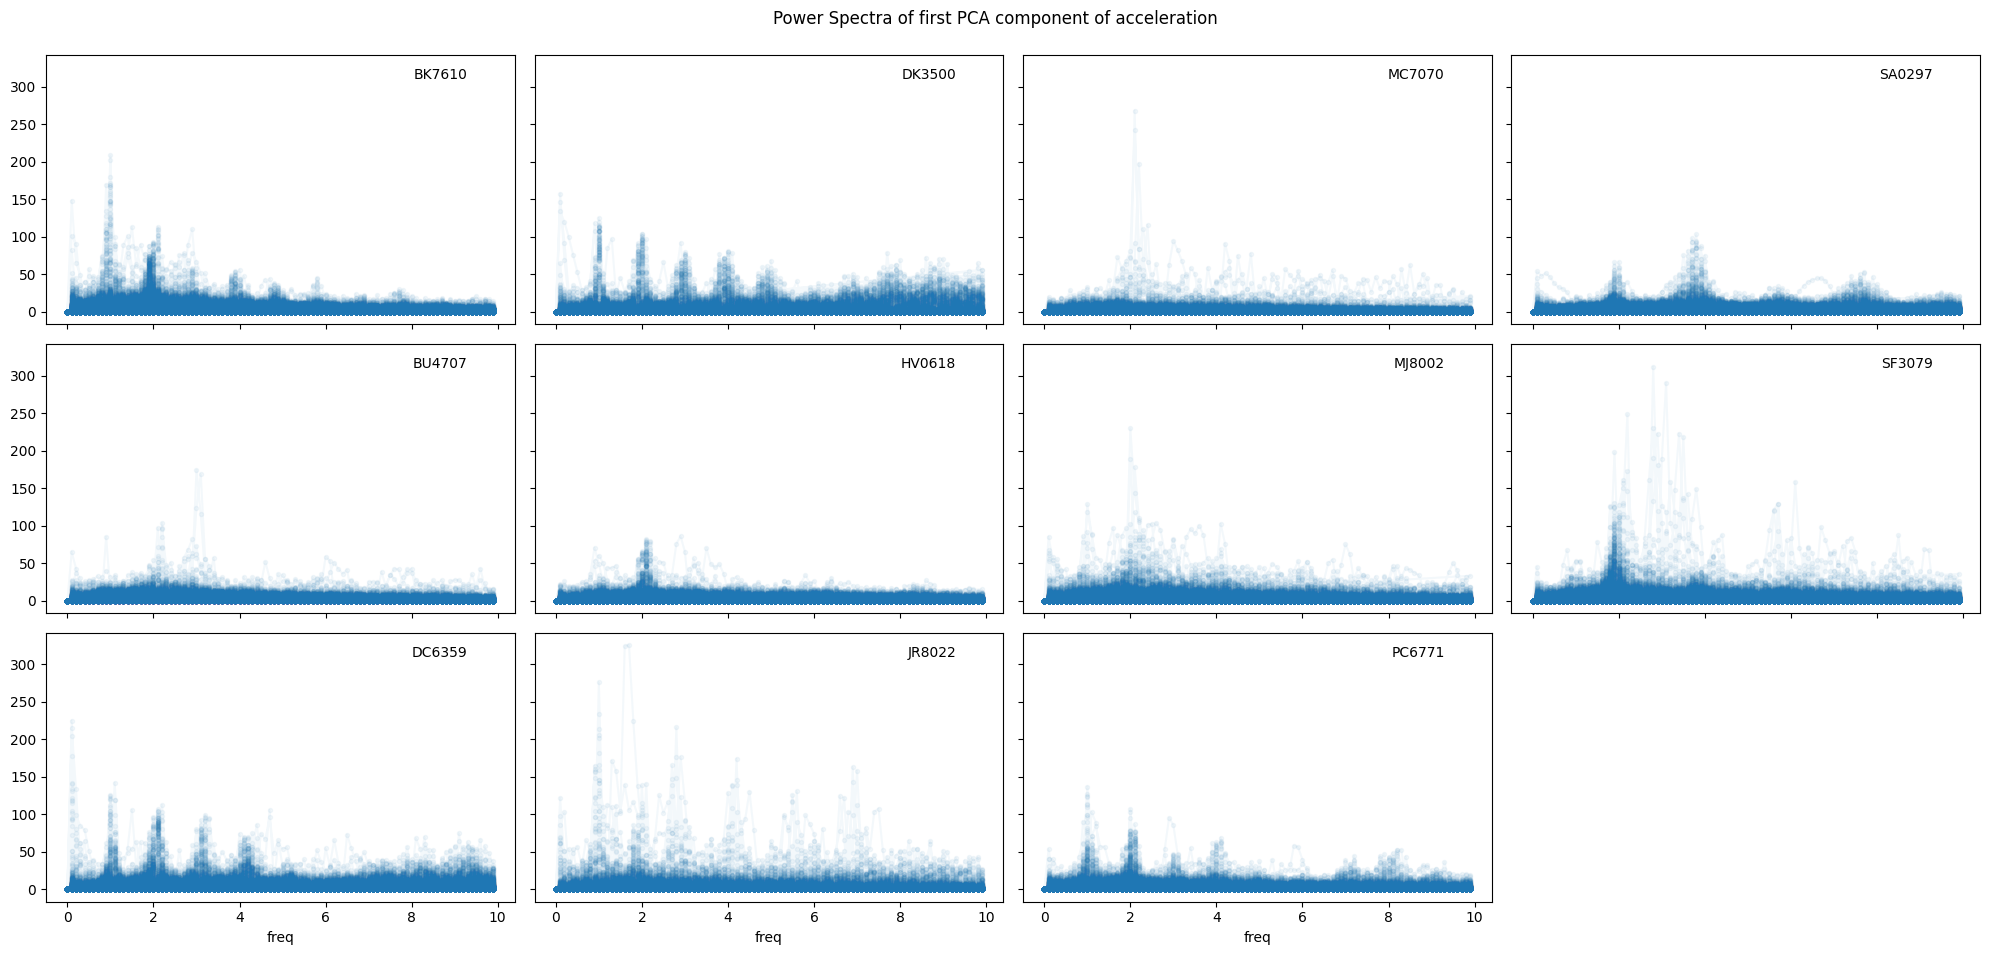

In [19]:
fig, ax = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)

for k, pid in enumerate(pid_list):
    i,j = get_ax_ij(k,ax)
    df = subject_data[pid]['sample_fft']

    df.plot(x='freq', y = ['C1'], 
        marker = '.', linestyle = None, alpha = 0.05, 
        ax = ax[i,j], legend=False)
    
    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)
    
fig.delaxes(ax[2,3])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Power Spectra of first PCA component of acceleration')
plt.show()

## Observations

The spectra of the first principle component look sensible. Most of the time, subjects aren't moving much, hence a dense band across the bottom of the spectrum (low-power white spectrum) with peaks corresponding to activity.

 - Subjects show peaks at around 2 Hz, which is nominal walking frequency.
 - That the peaks around 2 Hz are blurred (not sharp) suggests variable walking frequency. The harmonics (peaks at multiples of 2 Hz) define the "shape" of the walking gait.
 - Peaks below 2 Hz are some other slow oscillatory movement.

<a id='features'></a>
# Statistics, normalization, and feature creation



In [20]:
from BarCrawl_helpers import *

import numpy as np
import pandas as pd

import re as re
from tqdm import tqdm

import sys
import warnings

warnings.filterwarnings('ignore')

In [21]:
# If jumping into notebook at this section, this cell loads data processed previously

if exists('results/subject_data.p') and USE_SAVED:
    subject_data =pickle.load(open("results/subject_data.p","rb"))
    
pid_list = list(subject_data.keys())

pid0 = pid_list[0]

display(subject_data[pid0]['sample'].head())
display(subject_data[pid0]['sample_fft'].head())

,pid,sid,tac,time_s,x,y,z,C1,C2,rho,theta,phi,S1,S2
0,BK7610,0,0.056935,1.201,0.0397,-0.0047,0.0412,0.025795,-0.013848,0.057407,-0.117836,0.770333,34.799110,-0.608311
1,BK7610,0,0.056935,1.227,0.0147,-0.0177,0.0342,0.028346,0.006409,0.041219,-0.877720,0.592201,34.039246,-0.786428
2,BK7610,0,0.056935,1.251,0.0177,0.0116,0.0095,-0.005837,-0.009914,0.023197,0.580141,1.148845,35.497063,-0.229634
3,BK7610,0,0.056936,1.278,0.0222,0.0330,-0.0461,-0.065349,-0.006921,0.060886,0.978609,2.429745,35.895458,1.051144
4,BK7610,0,0.056936,1.304,0.0140,0.0194,-0.0559,-0.067762,0.011027,0.060804,0.945687,2.737196,35.862511,1.358592


,pid,sid,freq,x,y,z,C1,C2,rho,theta,phi,S1,S2
0,BK7610,0,0.0,0.889400,1.687000,4.049700,1.450589e-07,3.481273e-07,21.949293,13966.767654,552.298915,0.000230,0.000014
1,BK7610,0,0.1,1.288980,0.390355,1.275461,1.379868e+00,1.830318e-01,2.054008,6293.082292,12.593425,6293.080607,12.582646
2,BK7610,0,0.2,0.699293,0.356162,1.812915,1.697416e+00,7.019314e-01,7.248228,2954.434641,6.170344,2954.434198,6.183758
3,BK7610,0,0.3,1.328385,0.174959,1.919603,1.808376e+00,8.560074e-01,2.842827,1691.223743,21.702554,1691.223819,21.675013
4,BK7610,0,0.4,1.584343,0.323811,2.306874,2.234903e+00,9.965301e-01,3.421312,1358.079153,21.551089,1358.079580,21.493437


In [22]:
if exists('results/subject_stats.p') and USE_SAVED:
    subject_stats =pickle.load(open("results/subjects_stats.p","rb"))
else:
    subject_stats = {}

    for pid in tqdm(pid_list):
        print(pid)
        
        stats_temp = subject_data[pid]['sample'].groupby(['sid']).agg(['mean', 'std', 'max', 'min'])

        # stats_temp = subject_data[pid]['sample'].drop(columns = 'time_s').groupby(['sid']).agg(['mean', 'std', 'max', 'min'])
        # stats_temp.drop(columns = ['tac_min', 'tac_mean', 'tac_std', 'time_s_min', 'time_s_max', 'time_s_std'], inplace=True, errors = 'ignore')
        # stats_temp.rename(columns = {'tac_max':'tac'}, inplace=True)
        # stats_temp.rename(columns = {'time_s_mean':'time_s'}, inplace=True)
        
        # stats_fft_temp = subject_data[pid]['sample_fft'].drop(columns='freq').groupby(['pid', 'sid']).agg([power, dc, peak, peak_freq])
        stats_fft_temp = subject_data[pid]['sample_fft'].drop(columns='freq').groupby(['sid']).agg([power, peak, peak_freq])

        
        # join time-domain and frequency-domain stats
        subject_stats[pid] = stats_temp.join(stats_fft_temp)
        
        
        # combine the multi-index column names into single string
        col_names = subject_stats[pid].columns.to_flat_index().values
        subject_stats[pid].columns = ['_'.join(col_name) for col_name in col_names]
        
        subject_stats[pid].drop(columns = ['tac_min', 'tac_mean', 'tac_std', 'time_s_mean', 'time_s_max', 'time_s_std'], inplace=True, errors = 'ignore')
        subject_stats[pid].rename(columns = {'tac_max':'tac'}, inplace=True)
        subject_stats[pid].rename(columns = {'time_s_min':'time_s'}, inplace=True)

        
    print('...done.')
    pickle.dump(subject_stats, open("results/subject_stats.p","wb"))

  0%|          | 0/11 [00:00<?, ?it/s]

BK7610


  9%|▉         | 1/11 [00:14<02:25, 14.60s/it]

BU4707


 18%|█▊        | 2/11 [00:19<01:21,  9.10s/it]

DC6359


 27%|██▋       | 3/11 [00:26<01:05,  8.13s/it]

DK3500


 36%|███▋      | 4/11 [00:39<01:10, 10.11s/it]

HV0618


 45%|████▌     | 5/11 [00:53<01:07, 11.19s/it]

JR8022


 55%|█████▍    | 6/11 [00:56<00:43,  8.61s/it]

MC7070


 64%|██████▎   | 7/11 [01:00<00:28,  7.04s/it]

MJ8002


 73%|███████▎  | 8/11 [01:07<00:21,  7.18s/it]

PC6771


 82%|████████▏ | 9/11 [01:25<00:20, 10.27s/it]

SA0297


 91%|█████████ | 10/11 [01:32<00:09,  9.49s/it]

SF3079


100%|██████████| 11/11 [01:40<00:00,  9.15s/it]

...done.


In [23]:
subject_stats[pid].head()

,tac,time_s,x_mean,x_std,x_max,x_min,y_mean,y_std,y_max,y_min,...,theta_peak_freq,phi_power,phi_peak,phi_peak_freq,S1_power,S1_peak,S1_peak_freq,S2_power,S2_peak,S2_peak_freq
sid,,,,,,,,,,,,,,,,,,,,,
0,0.205462,1.201,0.001018,0.006880,0.0452,-0.0392,0.007704,0.005977,0.0485,-0.0487,...,0.1,382.355900,28.150819,7.9,1148.786496,935.354127,0.1,117.105301,27.985692,7.9
1,0.205437,8.705,0.001057,0.006846,0.0246,-0.0348,0.007009,0.007078,0.0762,-0.0314,...,0.1,438.323356,42.461314,8.4,935.027950,560.373002,0.1,148.338112,42.438986,8.4
2,0.205412,16.208,0.001046,0.004063,0.0131,-0.0116,0.006704,0.005401,0.0762,-0.0138,...,0.1,383.645530,60.459859,8.0,1946.157575,1691.356219,0.1,133.304586,60.453027,8.0
3,0.205387,23.729,0.000716,0.003890,0.0331,-0.0186,0.007892,0.003787,0.0150,-0.0520,...,0.1,339.252166,30.638164,8.1,1751.209972,1563.746336,0.1,87.714257,30.485862,8.1
4,0.205362,31.272,0.000613,0.016436,0.0641,-0.1169,0.006727,0.010555,0.0615,-0.0551,...,0.1,433.167970,41.552173,0.1,2652.873250,1636.550931,0.1,134.428222,35.351651,0.4


<a id='features'></a>
## Features, Targets, and Annotation

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [25]:
targets = {}
features = {}
anno = {}

for pid in pid_list:
    targets[pid] = pd.DataFrame({'tac':subject_stats[pid]['tac'],
                                'isOverLimit': 1.0*(subject_stats[pid]['tac']>TAC_limit)})
    
    features[pid] = subject_stats[pid].drop(columns=['time_s','tac'])

    anno[pid] = subject_stats[pid]['time_s']

In [26]:
display(features[pid].head(2))
display(targets[pid].head(2))
display(anno[pid].head(5))

,x_mean,x_std,x_max,x_min,y_mean,y_std,y_max,y_min,z_mean,z_std,...,theta_peak_freq,phi_power,phi_peak,phi_peak_freq,S1_power,S1_peak,S1_peak_freq,S2_power,S2_peak,S2_peak_freq
sid,,,,,,,,,,,,,,,,,,,,,
0,0.001018,0.006880,0.0452,-0.0392,0.007704,0.005977,0.0485,-0.0487,0.008409,0.013547,...,0.1,382.355900,28.150819,7.9,1148.786496,935.354127,0.1,117.105301,27.985692,7.9
1,0.001057,0.006846,0.0246,-0.0348,0.007009,0.007078,0.0762,-0.0314,0.007769,0.008915,...,0.1,438.323356,42.461314,8.4,935.027950,560.373002,0.1,148.338112,42.438986,8.4


,tac,isOverLimit
sid,,
0,0.205462,1.0
1,0.205437,1.0


sid
0     1.201
1     8.705
2    16.208
3    23.729
4    31.272
Name: time_s, dtype: float64

In [27]:
scaler = StandardScaler()
cols = features[pid].columns

for pid in pid_list:
    data_scaled = scaler.fit_transform(features[pid])
    features[pid] = pd.DataFrame(data_scaled, columns = cols)

In [28]:
features_df = pd.concat(features)
targets_df = pd.concat(targets)
anno_df = pd.concat(anno)

pickle.dump((features_df, targets_df, anno_df), open("results/features_targets_anno.p","wb"))


 <a id='models'></a>
## Modeling and Assessment

Using the feature and target data above to train classifiers, I'll be fitting and comparing the following classifiers:

 - Random Forest
 - Boosted Random Forest (XGBoost)
 - Neural Networks




In [29]:
import numpy as np
import pandas as pd
import re

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn import metrics
from sklearn_evaluation import plot

import matplotlib.pyplot as plt

import pickle
from os.path import exists

if exists('results/features_targets.p'):
    features_df, targets_df = pickle.load(open("results/features_targets.p", "rb"))

There's a new sklearn-evaluation version available (0.8.3), you're running 0.8.2. To upgrade: pip install sklearn-evaluation --upgrade


In [30]:
frac = lambda x: sum(x)/len(x)

X = features_df.to_numpy()
y = targets_df['isOverLimit'].to_numpy()

kfcv = StratifiedKFold(n_splits = 5, random_state = 3, shuffle = True)

scoring = ['accuracy', 'recall', 'precision', 'f1']


print('Fraction of training and testing samples that are positives (TAC over the limit):\n')

for train_idx, test_idx in kfcv.split(X,y):
    y_train, y_test = y[train_idx], y[test_idx]
    print(f'Training: {frac(y_train)} \tTesting:{frac(y_test)}\tCheck Sum:{sum(y_train)+sum(y_test)}')

print(f'\nFraction of positives in full set: {frac(y)} \tCheck Sum: {sum(y)}')

# Full data test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



Fraction of training and testing samples that are positives (TAC over the limit):

Training: 0.3185966155754408 	Testing:0.31856839121190644	Check Sum:8990.0
Training: 0.3185966155754408 	Testing:0.31856839121190644	Check Sum:8990.0
Training: 0.3185966155754408 	Testing:0.31856839121190644	Check Sum:8990.0
Training: 0.31858250276854927 	Testing:0.3186248449406344	Check Sum:8990.0
Training: 0.31858250276854927 	Testing:0.3186248449406344	Check Sum:8990.0

Fraction of positives in full set: 0.3185909703026437 	Check Sum: 8990.0


The distribution of positive cases in the training/testing sets is relatively uniform and consistent with the fraction of positive cases in the full data set.

### Random Forest Classifier

In [32]:
if exists('results/rafo_best.p') and USE_SAVED:
    rafo_best =pickle.load(open("results/rafo_best.p","rb"))
else:
    rafo_params = {
        'n_estimators':[200, 400],
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 20]
    }

    rafo_classifier = GridSearchCV(estimator = RandomForestClassifier(), 
        param_grid = rafo_params, cv = kfcv,
        refit = 'f1', scoring = scoring, 
        n_jobs = -1)

    rafo_best = rafo_classifier.best_estimator_
    rafo_best.fit(X_train,y_train)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3886
         1.0       0.96      0.97      0.96      1758

    accuracy                           0.98      5644
   macro avg       0.97      0.97      0.97      5644
weighted avg       0.98      0.98      0.98      5644



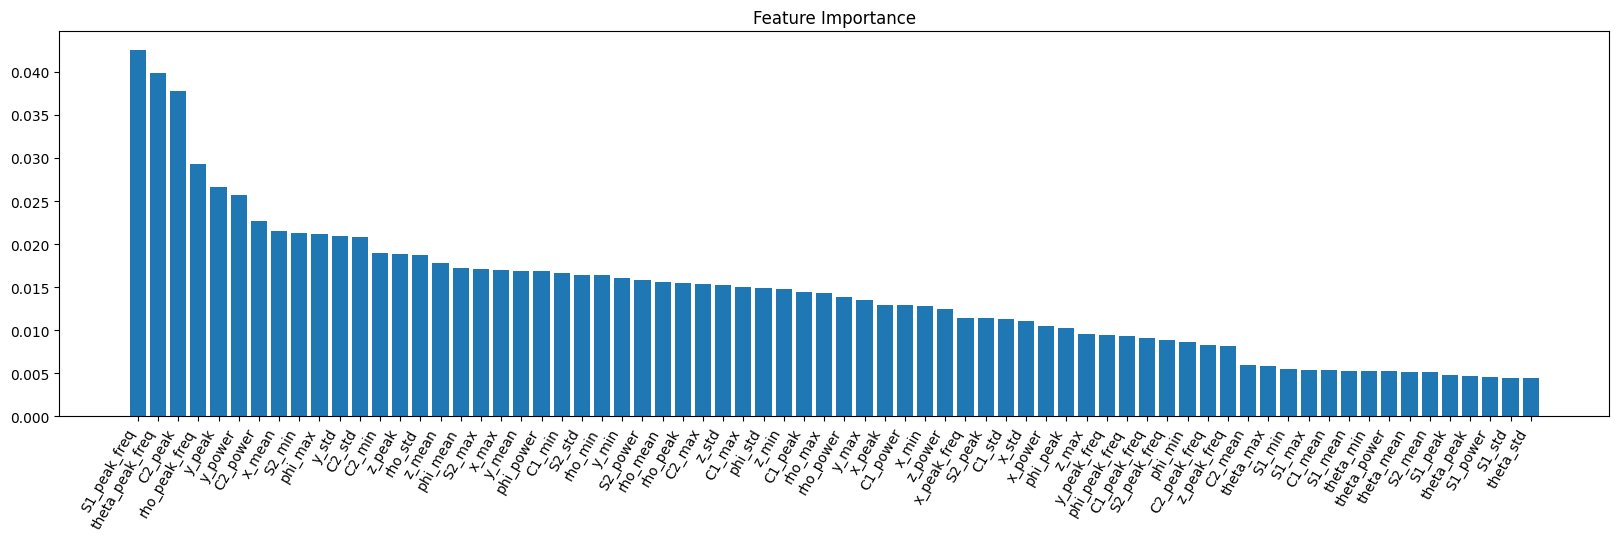

In [34]:
y_pred = rafo_best.predict(X_test)>0.5

rafo_results = metrics.classification_report(y_test, y_pred)
rafo_confusion = metrics.confusion_matrix(y_test, y_pred, normalize='true')

print(rafo_results)

plot_feature_importance(rafo_best, cols)
plt.show()



In [ ]:
# Save model
pickle.dump(rafo_best, open('results/rafo_best.p', "wb"))

### Boosted Decision Trees (XGBoost)

In [36]:
from xgboost import XGBClassifier

if exists('results/xgb_best.p') and USE_SAVED:
    xgb_best =pickle.load(open("results/xgb_best.p","rb"))
else:
    xgb_params = {
        'objective': ['binary:logistic', 'binary:hinge'],
        'n_estimators': [100, 200, 400],
        'max_depth': [5, 10, 20],
        'learning_rate':[0.1, 0.05, 0.025]
    }

    xgb_classifier = GridSearchCV(estimator = XGBClassifier(),
        param_grid=xgb_params, cv = kfcv,
        refit = 'f1', scoring = scoring,
        n_jobs=-1)

    xgb_classifier.fit(X,y)

    xgb_best = xgb_classifier.best_estimator_
    xgb_best.fit(X_train,y_train)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3886
         1.0       0.98      0.96      0.97      1758

    accuracy                           0.98      5644
   macro avg       0.98      0.98      0.98      5644
weighted avg       0.98      0.98      0.98      5644



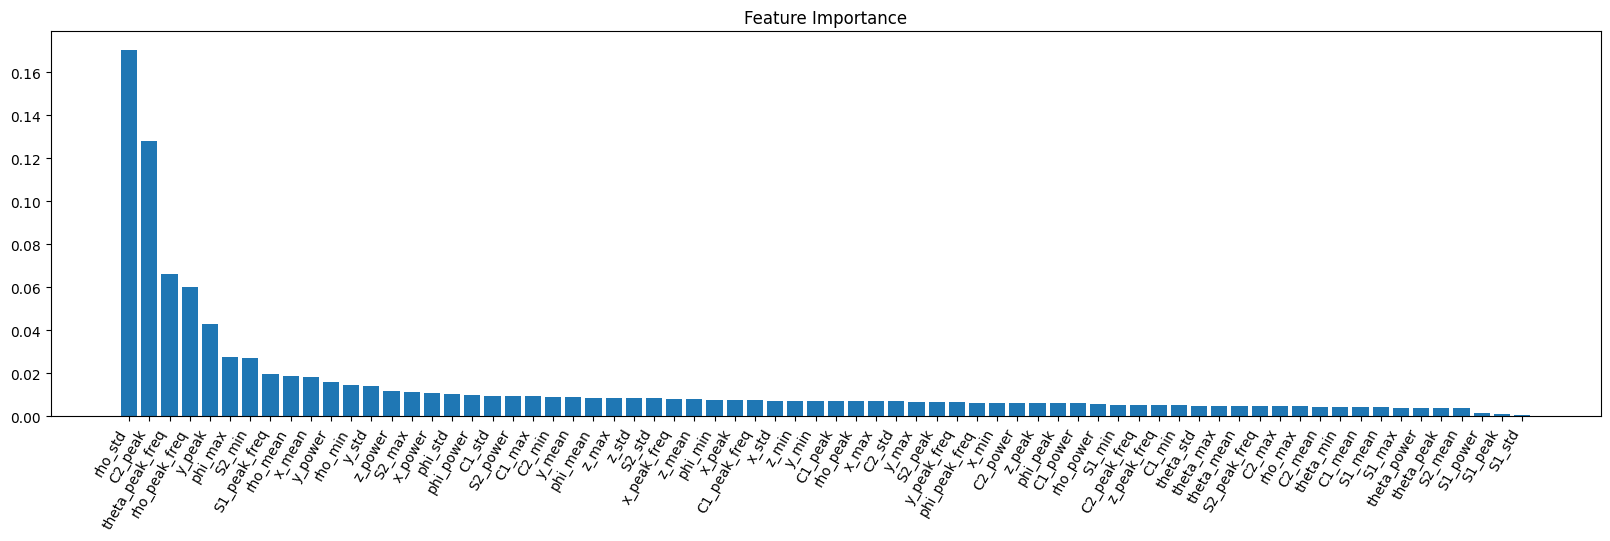

In [37]:
y_pred = xgb_best.predict(X_test)>0.5

xgb_results = metrics.classification_report(y_test, y_pred)
xgb_confusion = metrics.confusion_matrix(y_test, y_pred, normalize='true')

print(xgb_results)

plot_feature_importance(xgb_best, cols)
plt.show()

In [38]:
# Save model
pickle.dump(xgb_best, open('results/xgb_best.p', "wb"))

#### Observations

Interesting to note that the spherical coordinates contribute prominantly to the classification power of the random forest and boosted random forest. 





### Neural Network

In [39]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, Precision, Recall, AUC
import keras.regularizers as regularizers
from keras.backend import clear_session
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics

2022-12-12 18:40:28.168726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
X_train.shape

(22574, 70)

In [50]:
num_inputs = X_train.shape[1]
print(X_train.shape)

clear_session()

if exists('results/nn_best.p') and USE_SAVED:
    nn_classifier =pickle.load(open("results/nn_best.p","rb"))
else:

    input = Input(shape=(num_inputs,))
    lay1 = Dense(units = 256, activation = 'relu')(input)
    lay2 = Dropout(0.5)(lay1)
    lay3 = Dense(units = 128, activation = 'relu')(lay2)
    # lay4 = Dropout(0.5)(lay3)
    # lay5 = Dense(units = 16, activation = 'relu')(lay4)

    # lay2 = Dense(units = 80, activation = 'relu')(lay1)
    # lay3 = Dense(units = 16, activation = 'relu')(lay2)
    # lay2 = Dense(units = 50, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(lay1)
    output = Dense(units = 1, activation = 'sigmoid')(lay3)

    nn_classifier = Model(input,output)

    nn_classifier.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics = [BinaryCrossentropy(name='bce'), Recall(name='rec'), Precision(name='prec'), AUC(name='auc')])
    nn_history = nn_classifier.fit(X_train, y_train, 
        batch_size=16, epochs=200, shuffle=True,
        validation_data=(X_test, y_test), 
        verbose = 5)

    # Evaluate training hyper-params
    training_log = nn_history.history
    train_loss = training_log['loss']
    val_loss = training_log['val_loss']

    train_recall = training_log['rec']
    val_recall = training_log['val_rec']

    train_precision = training_log['prec']
    val_precision = training_log['val_prec']

    train_auc = training_log['auc']
    val_auc = training_log['val_auc']

    fig, ax = plt.subplots(3,1, figsize=(9,6), sharex = True)

    # Plot training metrics vs epochs
    ax[0].plot(train_recall, label = 'training')
    ax[0].plot(val_recall, label = 'validation')
    ax[0].set_ylabel('Recall')

    ax[1].plot(train_precision, label = 'training')
    ax[1].plot(val_precision, label = 'validation')
    ax[1].set_ylabel('Precision')

    ax[2].plot(train_auc, label = 'training')
    ax[2].plot(val_auc, label = 'validation')
    ax[2].set_ylabel('AUC')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Recall and Precision vs Training Epochs')

    ax[0].legend()
    ax[2].set_xlabel('Epochs')

    plt.show()

    # Create session log of trained trials as dataframe
    newLog = log_nn_training(nn_history)
    newLog['model'] = nn_classifier

    try:
        nn_trainingLog = pd.concat([nn_trainingLog, newLog], ignore_index=True)
    except:
        print('except')
        nn_trainingLog = newLog

    display(nn_trainingLog2.tail(20))

(22574, 70)
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-08 12:41:38         3391
metadata.json                                  2022-12-08 12:41:38           64
variables.h5                                   2022-12-08 12:41:38       870504
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer

In [51]:
# nn_results = cross_validate(nn_classifier, X, y, cv=kfcv, scoring=scoring)
y_pred = nn_classifier.predict(X_test)>0.5

nn_results = metrics.classification_report(y_test, y_pred,  digits=5)#, output_dict=True)
nn_confusion = metrics.confusion_matrix(y_test, y_pred, normalize='true')

print(nn_results)

177/177 [==============================] - 0s 836us/step
              precision    recall  f1-score   support

         0.0    0.96478   0.92331   0.94359      3886
         1.0    0.84519   0.92548   0.88352      1758

    accuracy                        0.92399      5644
   macro avg    0.90499   0.92440   0.91355      5644
weighted avg    0.92753   0.92399   0.92488      5644



In [ ]:
# Save model
best_model = -1     # set to index of best model from training log, otherwise, the most recently trained model

nn_best = nn_trainingLog['model'].iloc[-1]
pickle.dump(nn_best, open('results/nn_best.p', "wb"))

## Model Comparison

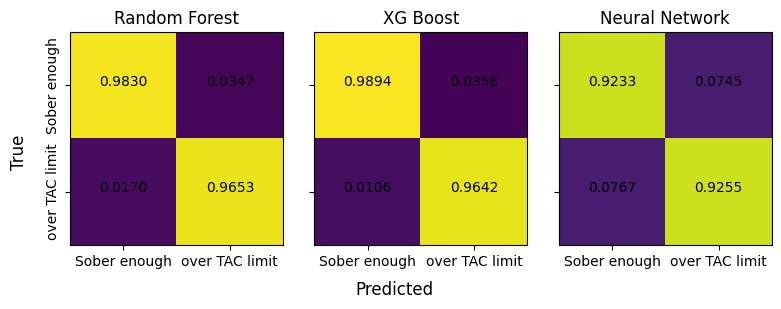

In [52]:
fig, ax = plt.subplots(1,3, figsize=(8,3), sharey=True, sharex=True)
fig.clf
labels = ['Sober enough', 'over TAC limit']

plot_confusion_mat(rafo_confusion, ax = ax[0], display_labels = labels)
ax[0].set_title('Random Forest')

plot_confusion_mat(xgb_confusion, ax = ax[1], display_labels = labels)
ax[1].set_title('XG Boost')

plot_confusion_mat(nn_confusion, ax = ax[2], display_labels = labels)
ax[2].set_title('Neural Network')

fig.supxlabel('Predicted')
fig.supylabel('True')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Observations

As trained in this analysis, XG Boost provides a marginal improvement over Random Forest. The neural network is inadequately designed/trained.

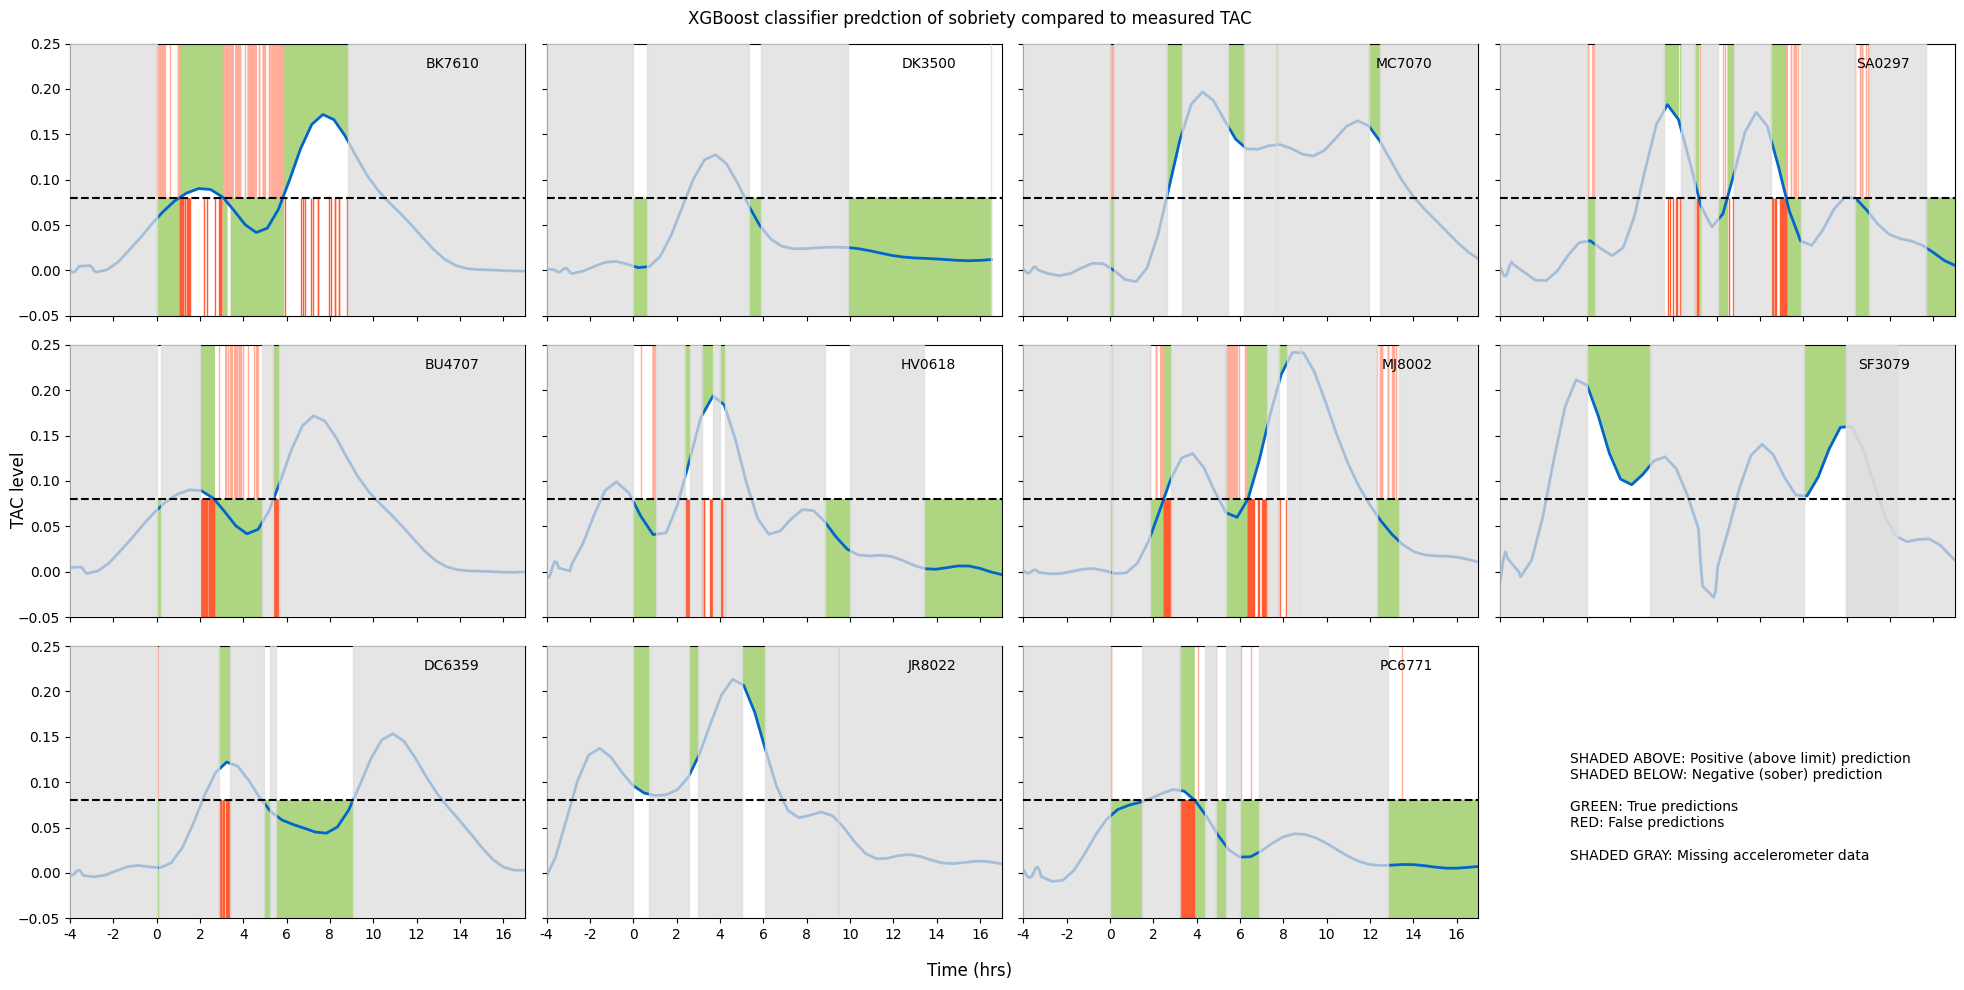

In [77]:
nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(20, 10), sharex=True, sharey=True)
ylim = [-0.05, 0.25]
TAC_limit = 0.08

sec_per_hour = 3600
start_hr = -4
end_hr = 17

TAC_COLOR = '#0066cc'
# OVER_COLOR =  

for k, pid in enumerate(pid_list):
    tac = tac_df[pid]['TAC_Reading'].to_numpy()
    ts = tac_df[pid]['time_s'].to_numpy()

    TAC = targets_df['tac'].loc[pid].to_numpy()
    y_true = targets_df['isOverLimit'].loc[pid].to_numpy()

    X_test = features_df.loc[pid].to_numpy()
    y_pred = rafo_best.predict(X_test, ) 
    t = anno_df.loc[pid].to_numpy()

    i,j = get_ax_ij(k, ax)
    
    ax[i,j].plot(ts, tac, color = TAC_COLOR, linewidth=2)
    ax[i,j].set_ylim([-0.05, 0.25])

 
    ax[i,j].set_xlim(np.array([start_hr, end_hr])*sec_per_hour)
    ax[i,j].set_xticks(np.arange(start_hr*sec_per_hour, end_hr*sec_per_hour, 2*sec_per_hour))
    ax[i,j].set_xticklabels(np.arange(start_hr, end_hr,2))

    band_idx = parse_array(t, 900)
    gap_start_times = np.append(ts[0], t[band_idx[:,1].ravel()-1])
    gap_end_times = np.append(t[band_idx[:,0].ravel()], ts[-1])
    gap_times = np.vstack((gap_start_times, gap_end_times)).transpose()

    for gap in gap_times:
        # print(gap)
        ax[i,j].axvspan(gap[0], gap[1],color = '#DDDDDD', alpha = 0.75,zorder=3)

    ax[i,j].axhline(TAC_limit, linestyle = '--', color = 'k', zorder = 4)

    for band in band_idx:
        idx = np.arange(band[0], band[1], dtype=int)

        plot_confusion_time(t[idx], TAC[idx], y_true[idx], y_pred[idx], ax=ax[i,j],  alpha = 1.0)

    ax[i,j].text(0.9, 0.9, pid,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax[i,j].transAxes)

fig.delaxes(ax[2,3])      

fig.text(0.8, 0.1, "SHADED ABOVE: Positive (above limit) prediction\n"
    "SHADED BELOW: Negative (sober) prediction\n\n"
    "GREEN: True predictions\n"
    "RED: False predictions\n\n"
    "SHADED GRAY: Missing accelerometer data\n\n"
    , ma='left', wrap=True)

fig.suptitle('XGBoost classifier predction of sobriety compared to measured TAC')
fig.supylabel('TAC level')
fig.supxlabel('Time (hrs)')
plt.tight_layout()
plt.show()

### Observations

 - Green regions represent correct predictions. There's plenty of green.
 - There are many regions in which the prediction oscillates rapidly, bands of time with shaded regions above AND below the TAC signal.
 - For the most part, this population maodel does reasonably well for individuals.

### Recommendations/possibilities for improvement
 The TAC signal is the representation of the state of a dynamical system with hidden inputs (alcohol consumption). This classification begs a time-series analysis that these data just can't support. But, were we to deploy this as an app to promote responsible drinking and warn customers of elevated TAC, we could filter the classifier or add heuristics for safer results.
  - Lower threshold. For this application, a False negative is the more dangerous error. Moreover, people with TAC might still be impaired and below the legal limit. Better safe than sorry.
  - TAC is a continuous and relatively slowly changing signal (on the order of minutes as compared to the 10 s features used for the analysis). For fast oscillating labels, the classification can be filtered (consensus) over a longer window.
  - Recognizing that TAC rises and falls slowly, once an over-the-limit classification is decided, there should be some refractory period before sober classifications are trusted.